<a href="https://colab.research.google.com/github/DrKamaleshR/CVD-classification/blob/main/CVDriskclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

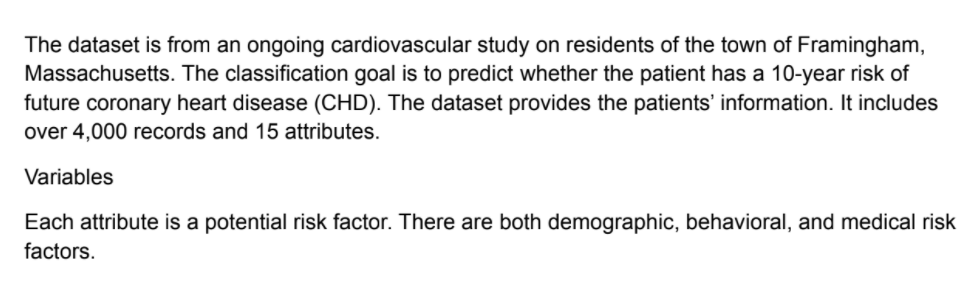

Data Description
Demographic:
- Sex: male or female("M" or "F")
- Age: Age of the patient;(Continuous - Although the recorded ages have been truncated to
whole numbers, the concept of age is continuous)
Behavioral
- is_smoking: whether or not the patient is a current smoker ("YES" or "NO")
- Cigs Per Day: the number of cigarettes that the person smoked on average in one day.(can be
considered continuous as one can have any number of cigarettes, even half a cigarette.)
Medical( history)
- BP Meds: whether or not the patient was on blood pressure medication (Nominal)
- Prevalent Stroke: whether or not the patient had previously had a stroke (Nominal)
- Prevalent Hyp: whether or not the patient was hypertensive (Nominal)
- Diabetes: whether or not the patient had diabetes (Nominal)
Medical(current)
- Tot Chol: total cholesterol level (Continuous)
- Sys BP: systolic blood pressure (Continuous)
- Dia BP: diastolic blood pressure (Continuous)
- BMI: Body Mass Index (Continuous)
- Heart Rate: heart rate (Continuous - In medical research, variables such as heart rate though in
fact discrete, yet are considered continuous because of large number of possible values.)
- Glucose: glucose level (Continuous)
Predict variable (desired target)
- 10-year risk of coronary heart disease CHD(binary: “1”, means “Yes”, “0” means “No”) -
DV





In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import chi2, chi2_contingency, f_oneway
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, recall_score, precision_score,\
 accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import Sequential, layers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
CVDfiledir='/content/drive/My Drive/almabetter projects/Cardiovascular Risk Prediction/data_cardiovascular_risk.csv'

In [5]:
CVDCdf= pd.read_csv(CVDfiledir)

In [7]:
CVDCdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3303 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3368 non-null   float64
 6   BPMeds           3346 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

In [9]:
CVDCdf.shape

(3390, 17)

In [10]:
CVDCdf.head()

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


In [ ]:
CVDCdf.head()

EXPLORATORY DATA ANALYSIS

In [11]:
#Checking for NaN values
CVDCdf.isnull().sum()

id                   0
age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

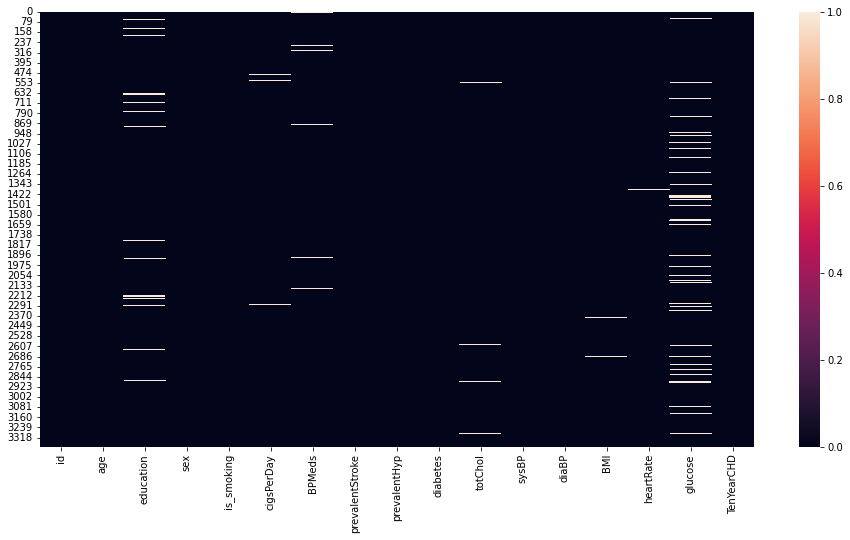

In [14]:
plt.figure(figsize=(16,8))
sns.heatmap(CVDCdf.isnull())

We can see education,cigsPerDay,BPMeds,totChol,BMI,heartRate and glucose have NaN values





In [16]:
CVDCdf.describe()

,id,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3390.000000,3390.000000,3303.000000,3368.000000,3346.000000,3390.000000,3390.000000,3390.000000,3352.000000,3390.00000,3390.000000,3376.000000,3389.000000,3086.000000,3390.000000
mean,1694.500000,49.542183,1.970936,9.069477,0.029886,0.006490,0.315339,0.025664,237.074284,132.60118,82.883038,25.794964,75.977279,82.086520,0.150737
std,978.753033,8.592878,1.019081,11.879078,0.170299,0.080309,0.464719,0.158153,45.247430,22.29203,12.023581,4.115449,11.971868,24.244753,0.357846
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.50000,48.000000,15.960000,45.000000,40.000000,0.000000
25%,847.250000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.00000,74.500000,23.020000,68.000000,71.000000,0.000000
50%,1694.500000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.50000,82.000000,25.380000,75.000000,78.000000,0.000000
75%,2541.750000,56.000000,3.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.00000,90.000000,28.040000,83.000000,87.000000,0.000000
max,3389.000000,70.000000,4.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.00000,142.500000,56.800000,143.000000,394.000000,1.000000


Handling missing values by replacing NaN values with mean for numeric values


In [17]:
CVDCdf['education'].fillna(2,inplace=True)
CVDCdf['cigsPerDay'].fillna(18,inplace=True)
CVDCdf['BPMeds'].fillna(0,inplace=True)
CVDCdf['totChol'].fillna(234,inplace=True)
CVDCdf['BMI'].fillna(25,inplace=True)
CVDCdf['heartRate'].fillna(75,inplace=True)
CVDCdf['glucose'].fillna(82,inplace=True)

In [18]:
CVDCdf.isnull().sum()

id                 0
age                0
education          0
sex                0
is_smoking         0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [ ]:
#Missing values handled

**UNIVARIATE** **ANALYSIS**

In [46]:
#Numeric Variables
CVDdfN=['age', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate','cigsPerDay','glucose']

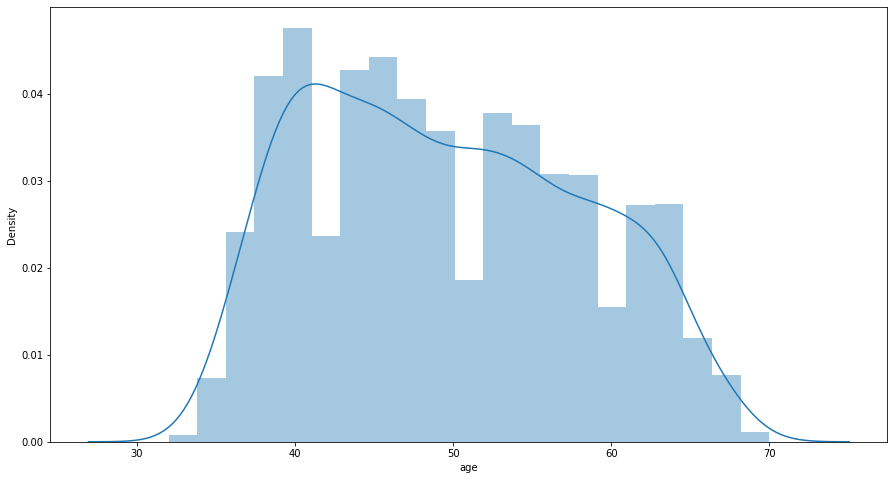

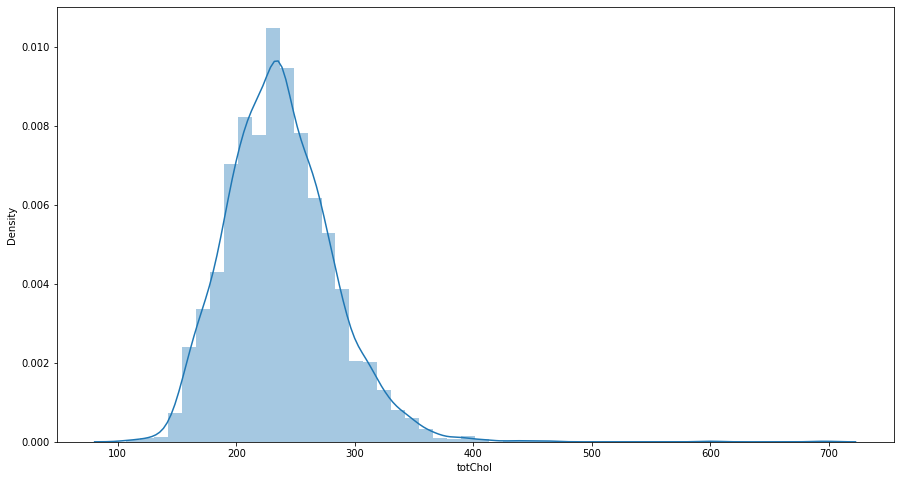

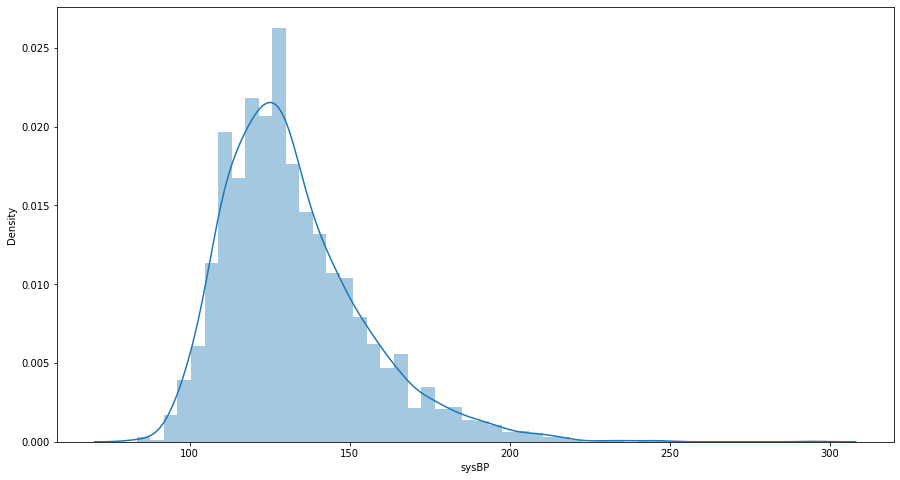

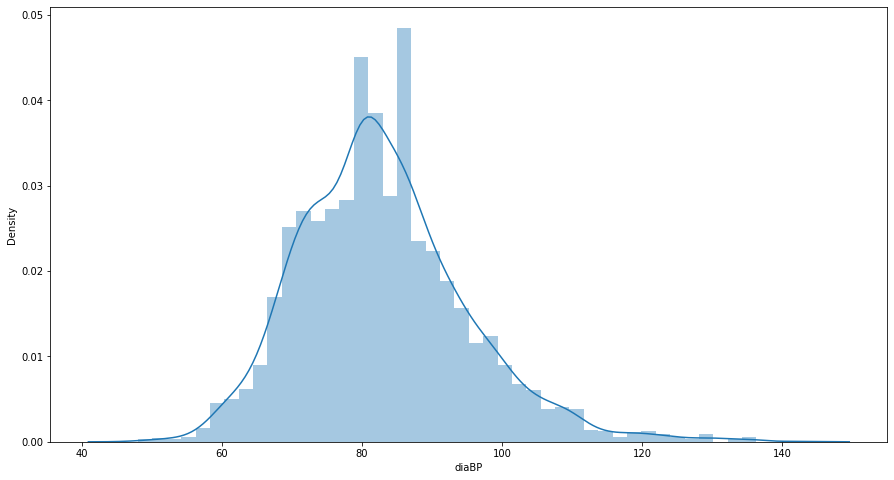

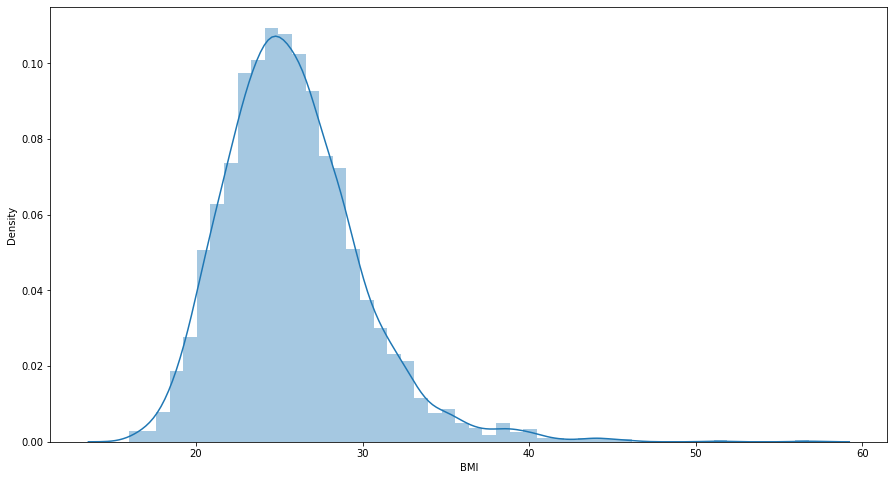

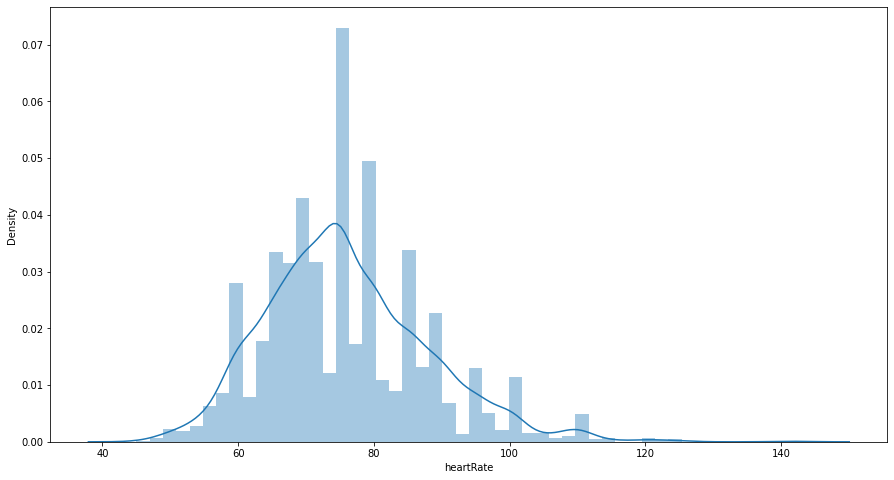

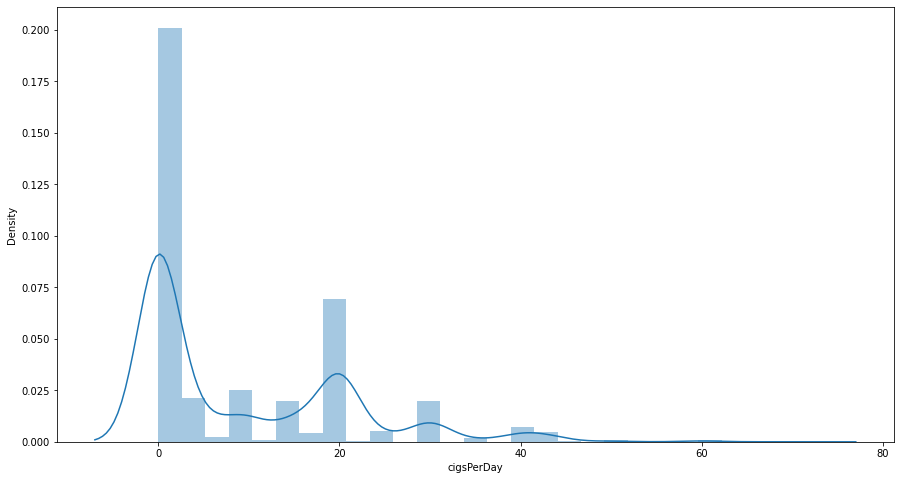

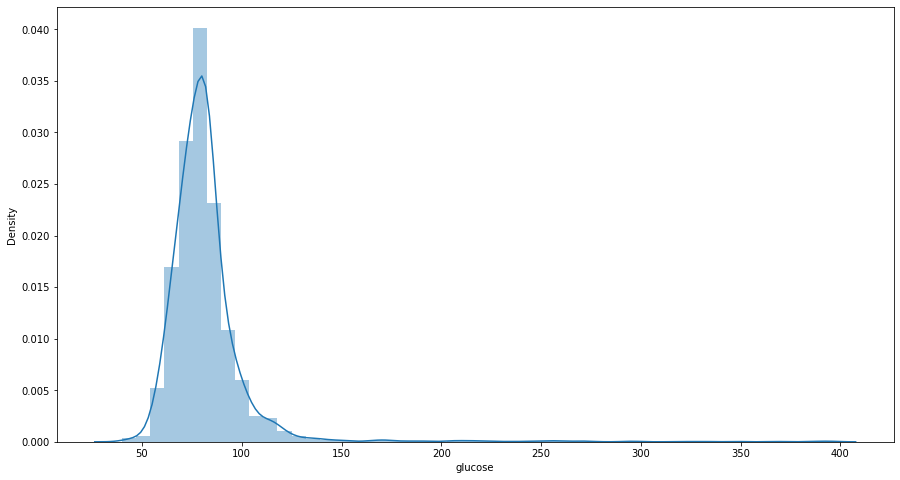

In [47]:
for i in CVDdfN:
  plt.figure(figsize=(15,8))
  sns.distplot(CVDCdf[i])

In [48]:
CVDdfC=['education', 'sex', 'is_smoking',  'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'TenYearCHD']

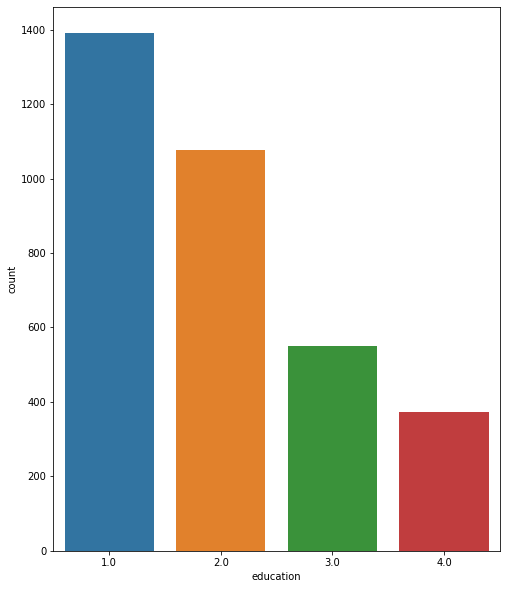

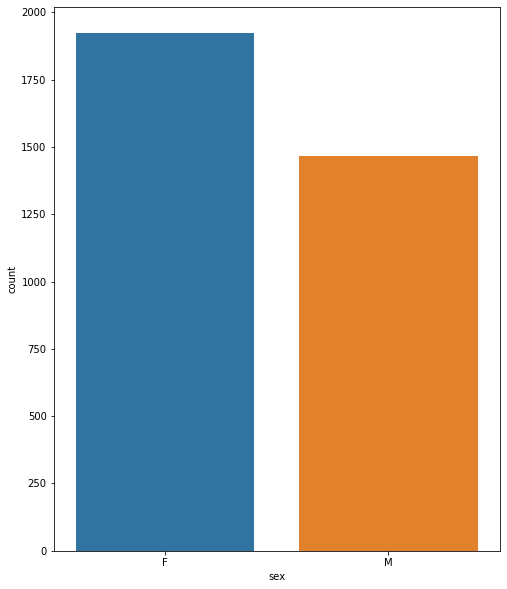

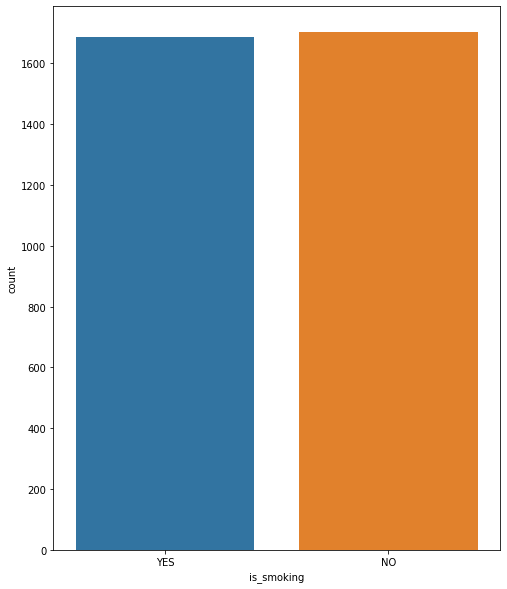

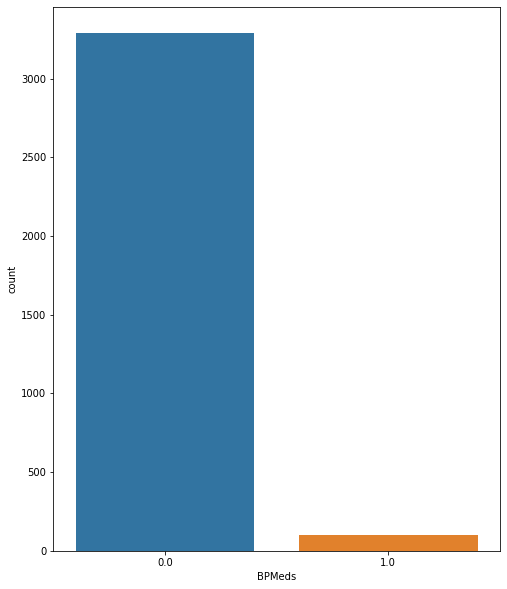

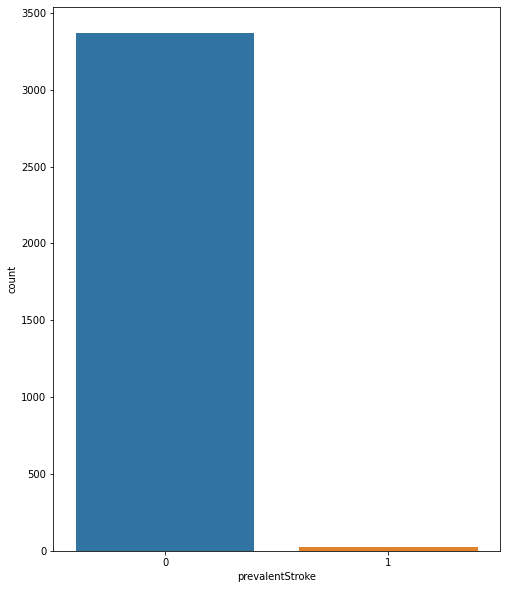

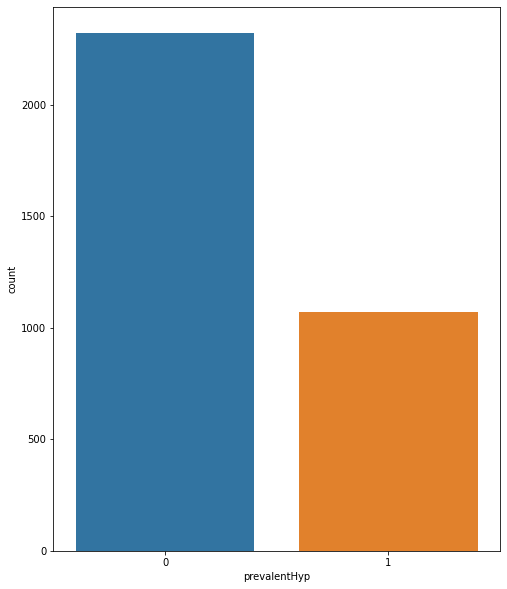

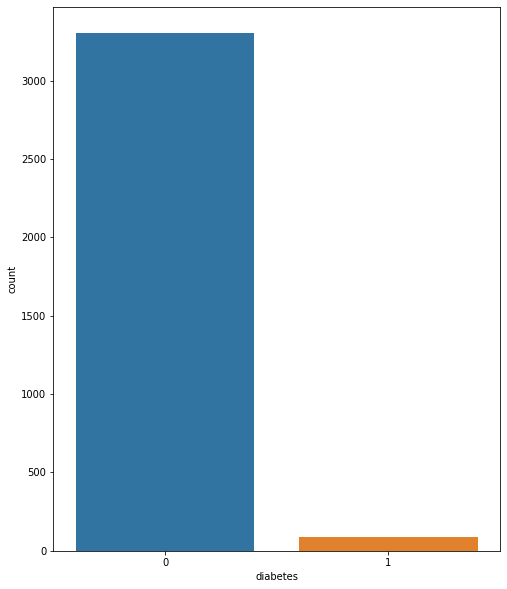

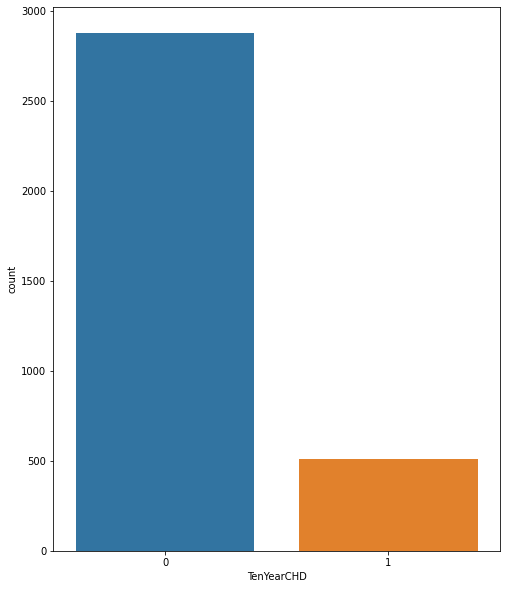

In [55]:
for i in CVDdfC:
  plt.figure(figsize=(8,10))
  sns.countplot(CVDCdf[i])

**BIVARIATE** **ANALYSIS**

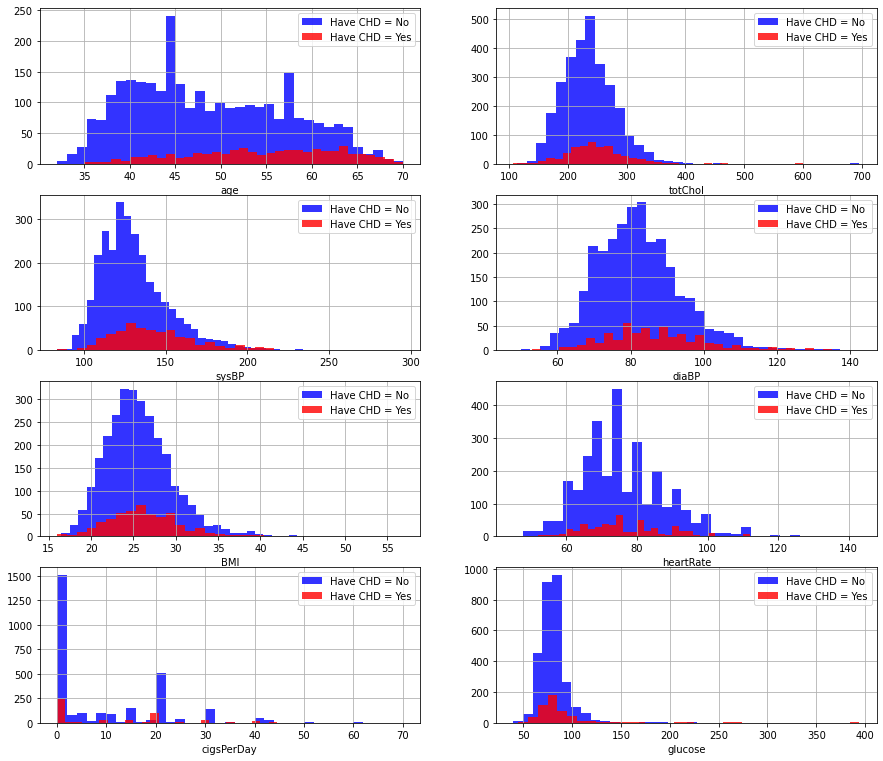

In [87]:
#Continous variables vs CHD incidence
plt.figure(figsize=(15, 20))

for i, column in enumerate(CVDdfN, 1):
    plt.subplot(6, 2, i)
    CVDCdf[CVDCdf["TenYearCHD"] == 0][column].hist(bins=35, color='blue', label='Have CHD = No', alpha=0.8)
    CVDCdf[CVDCdf["TenYearCHD"] == 1][column].hist(bins=35, color='red', label='Have CHD = Yes', alpha=0.8)
    plt.legend()
    plt.xlabel(column)

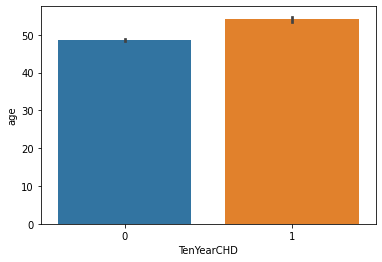

In [89]:
sns.barplot(x="TenYearCHD", y="age", data=CVDCdf)

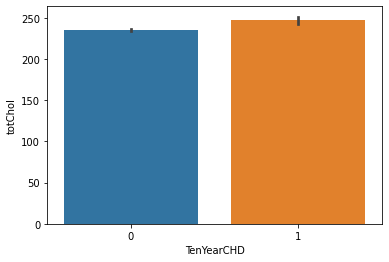

In [90]:
sns.barplot(x="TenYearCHD", y="totChol", data=CVDCdf)

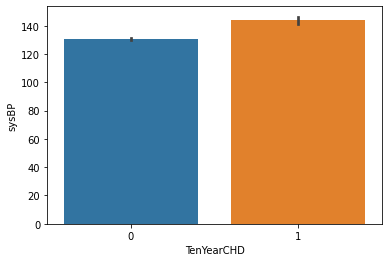

In [91]:
sns.barplot(x="TenYearCHD", y="sysBP", data=CVDCdf)

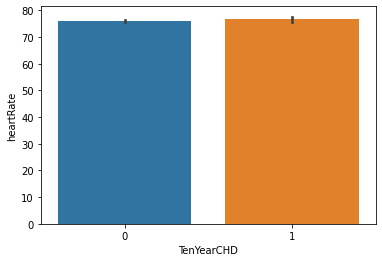

In [92]:
sns.barplot(x="TenYearCHD", y="heartRate", data=CVDCdf)

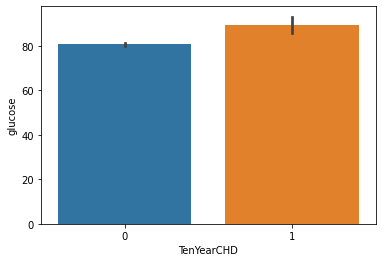

In [93]:
sns.barplot(x="TenYearCHD", y="glucose", data=CVDCdf)

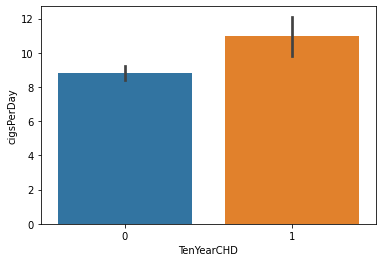

In [94]:
sns.barplot(x="TenYearCHD", y="cigsPerDay", data=CVDCdf)

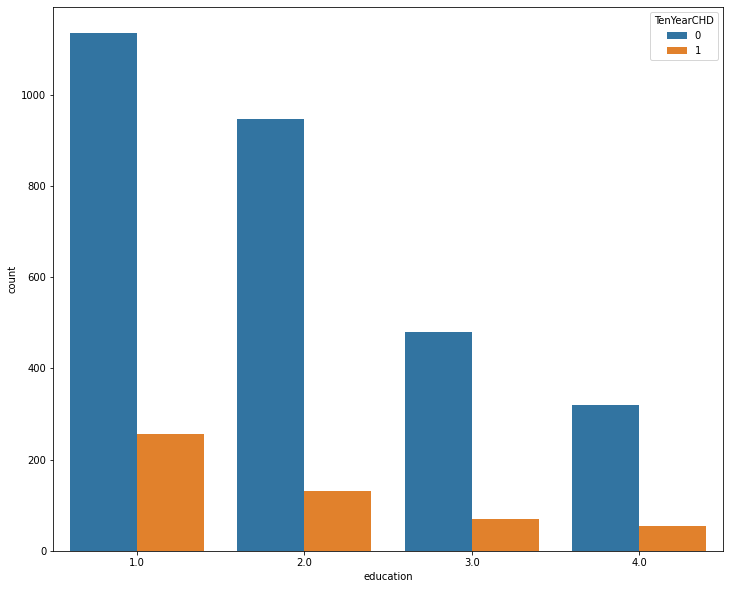

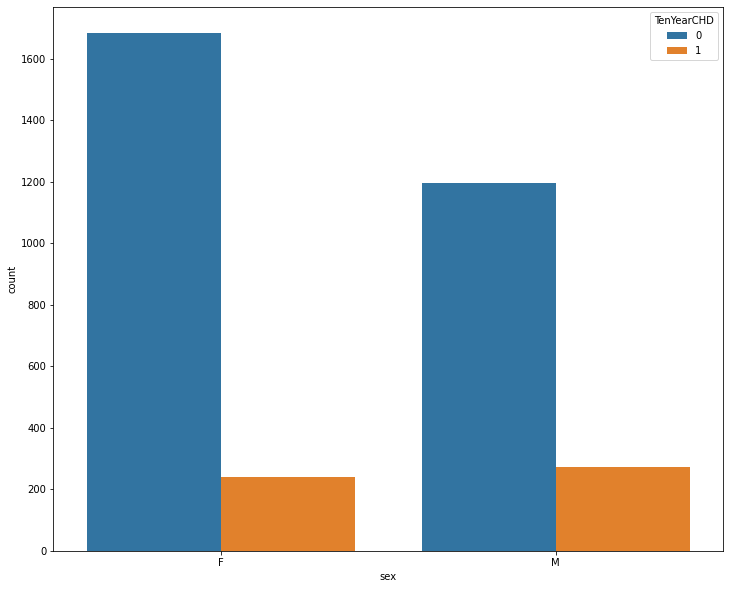

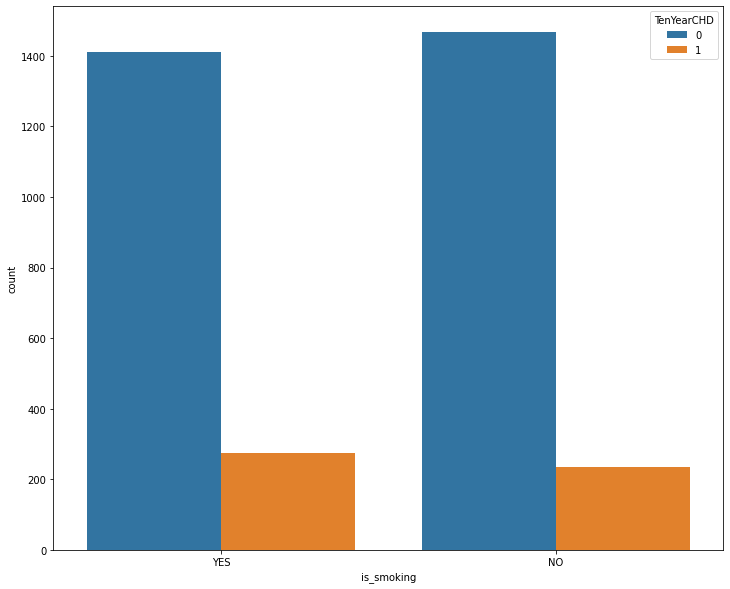

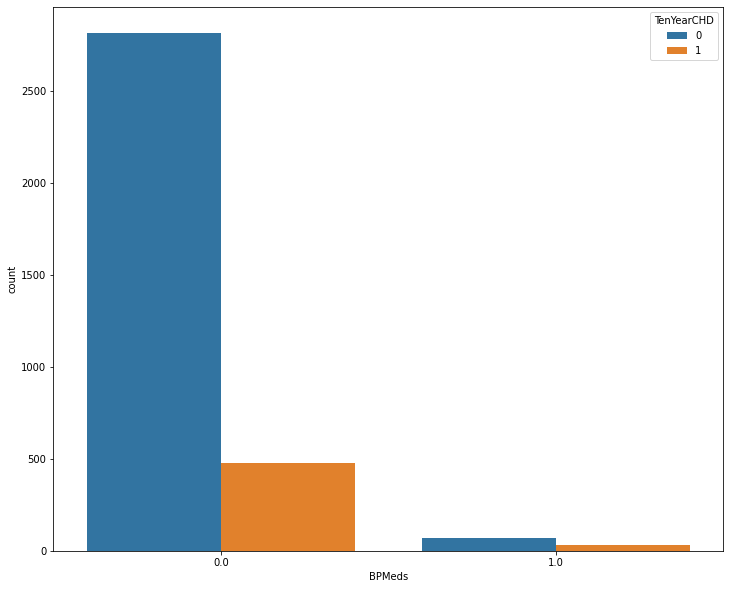

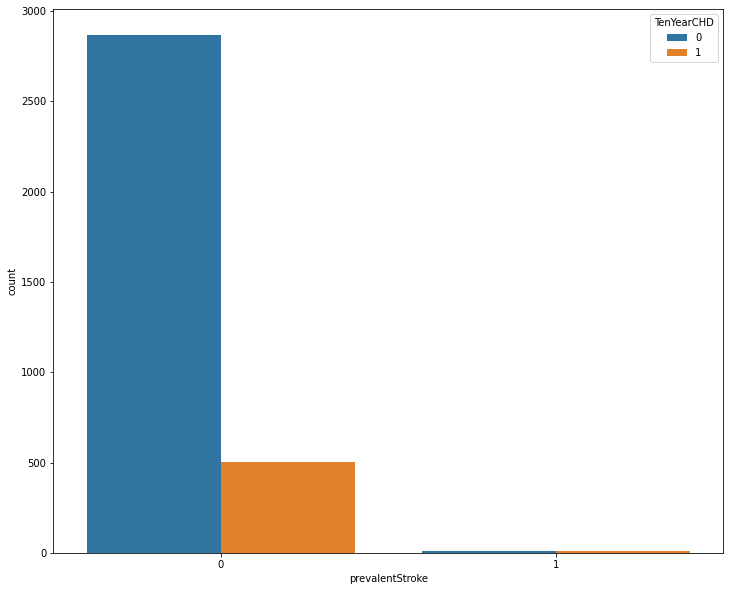

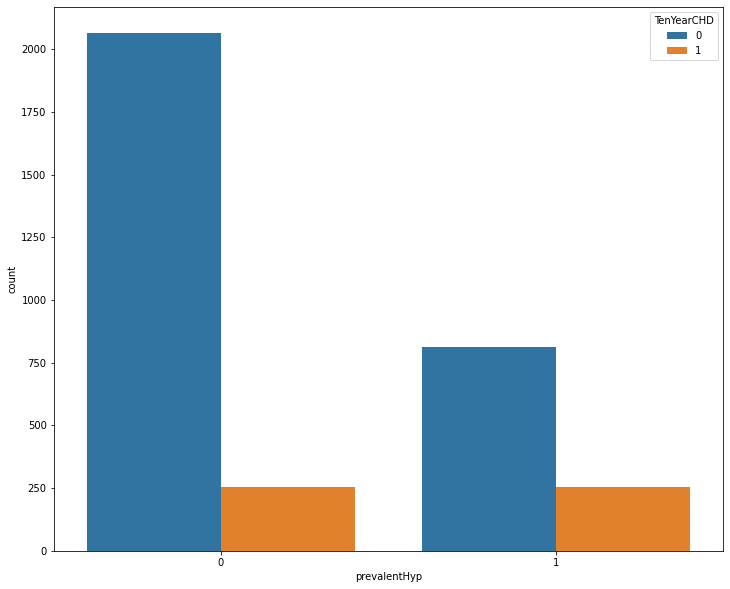

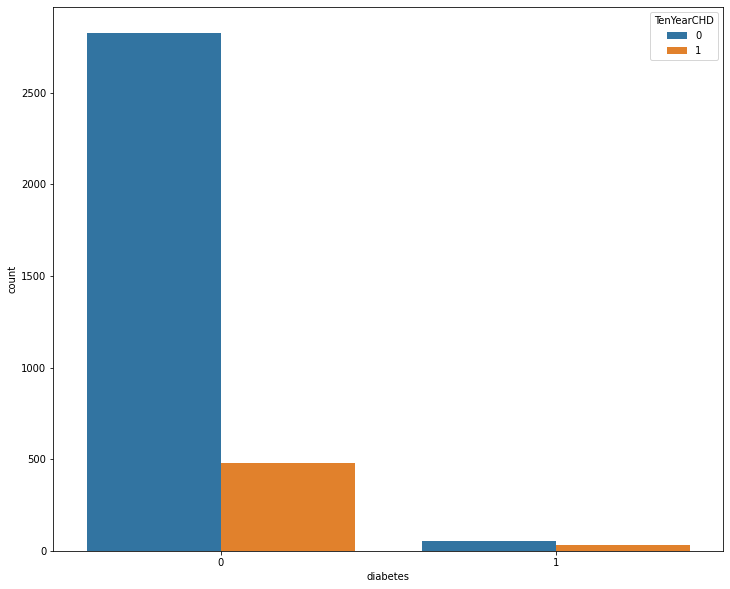

In [81]:
CVDdfC=['education', 'sex', 'is_smoking',  'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes']
for i in CVDdfC:
  plt.figure(figsize=(12,10))
  sns.countplot(CVDCdf[i],hue=CVDCdf['TenYearCHD'])